# 04_Evaluation Homework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Import the data

data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

!wget $data -O bank_marketing_data.csv

In [2]:
df = pd.read_csv('bank_marketing_data.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [5]:
df.shape

(1462, 9)

In [6]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

#### Set the categorical and numeric features

In [7]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numeric = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

### Data Preparation
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

In [8]:
# Identify the missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [9]:
df[categorical] = df[categorical].fillna('NA')

In [10]:
df[numeric] = df[numeric].fillna(0)

In [11]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Split the data
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
- Use train_test_split function for that with random_state=1

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [14]:
len(df_full_train), len(df_test)

(1169, 293)

In [15]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [16]:
len(df_train), len(df_val)

(876, 293)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [19]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
score = {}

for num in numeric:
    auc_val = roc_auc_score(y_train,df_train[num])
    score[num] = auc_val

In [22]:
score

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [23]:
corr_result = pd.DataFrame.from_dict(score,orient='index',columns=['Correlation'])
corr_result.index.name = 'Numeric Features'
corr_result.sort_values('Correlation', ascending=False)

,Correlation
Numeric Features,
number_of_courses_viewed,0.763568
interaction_count,0.738270
lead_score,0.614499
annual_income,0.551958


### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

In [25]:
val_dict = df_val[categorical + numeric].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [26]:
round(roc_auc_score(y_val, y_pred),3)

0.817

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [27]:
scores = []
thresholds = np.arange(0,1,step=0.01)

for t in thresholds:
    actual_posivite = (y_val ==1)
    actual_negative = (y_val ==0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <t)

    tp = (predict_positive & actual_posivite).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_posivite).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, tn, fp, fn, precision, recall))

/tmp/ipykernel_2745/1407049409.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [28]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn','precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [33]:
# Finding the intersection point
df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_idx = df_scores['diff'].idxmin()

intersection_point = df_scores.loc[intersection_idx, ['thresholds', 'precision', 'recall']]
print("Intersection point:")
print(intersection_point)

Intersection point:
thresholds    0.640000
precision     0.779070
recall        0.783626
Name: 64, dtype: float64


In [29]:
df_scores[::10]

,thresholds,tp,tn,fp,fn,precision,recall
0,0.0,171,0,122,0,0.583618,1.000000
10,0.1,171,0,122,0,0.583618,1.000000
20,0.2,171,0,122,0,0.583618,1.000000
30,0.3,171,3,119,0,0.589655,1.000000
40,0.4,171,17,105,0,0.619565,1.000000
50,0.5,164,41,81,7,0.669388,0.959064
60,0.6,150,69,53,21,0.738916,0.877193
70,0.7,106,97,25,65,0.809160,0.619883
80,0.8,64,116,6,107,0.914286,0.374269
90,0.9,24,121,1,147,0.960000,0.140351


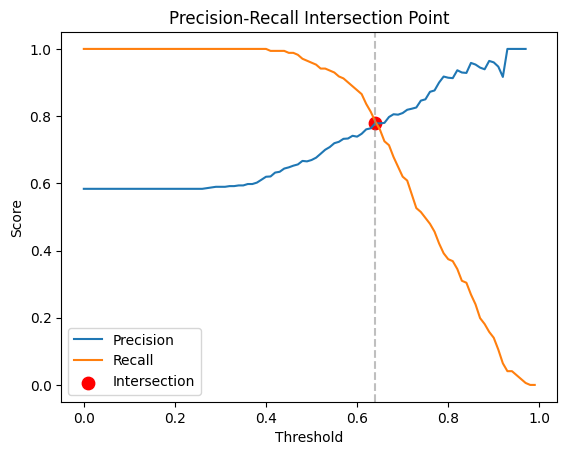

In [35]:
# Plotting the Precision and Recall and the intersection point

plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall')

# Mark the intersection
plt.scatter(
    intersection_point['thresholds'],
    intersection_point['precision'],
    color='red', s=80, label='Intersection'
)

plt.axvline(intersection_point['thresholds'], color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Intersection Point')
plt.show()

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

In [47]:
scores = []
thresholds = np.arange(0,1,step=0.01)

for t in thresholds:
    actual_posivite = (y_val ==1)
    actual_negative = (y_val ==0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <t)

    tp = (predict_positive & actual_posivite).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_posivite).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall/ (precision + recall)

    scores.append((t, tp, tn, fp, fn, precision, recall, f1_score))


columns = ['thresholds', 'tp', 'tn', 'fp', 'fn','precision', 'recall','f1_score']
df_scores = pd.DataFrame(scores, columns=columns)

best_idx = df_scores['f1_score'].idxmax()
best_threshold = df_scores.loc[best_idx, 'thresholds']
bestf1 = df_scores.loc[best_idx, 'f1_score']

/tmp/ipykernel_2745/3722653392.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


#### THreshold at which F1 is max

In [49]:
print('At %0.3f threshold, we get the max f1 score of %0.3f)' % (best_threshold,bestf1))

At 0.570 threshold, we get the max f1 score of 0.812)


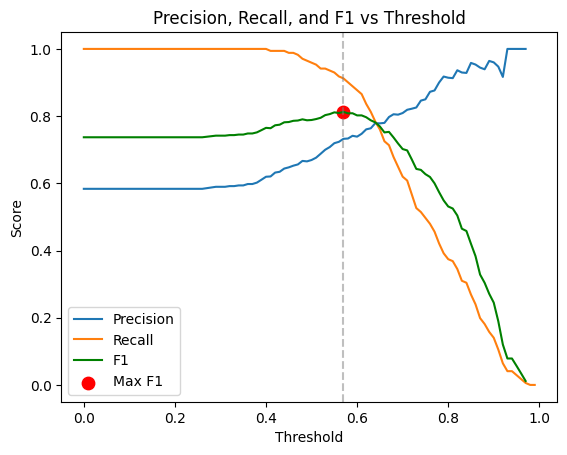

In [46]:
# Plotting it 

plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall')
plt.plot(df_scores.thresholds, df_scores['f1_score'], label='F1', color='green')

# Highlight max F1
plt.scatter(best_threshold, bestf1, color='red', s=80, label='Max F1')
plt.axvline(best_threshold, color='gray', linestyle='--', alpha=0.5)

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.show()

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

In [52]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [51]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [68]:
def train(df, y_train):
    dicts = df[categorical + numeric].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [69]:
def predict(df, dv, model):
    dicts = df[categorical + numeric].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [74]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('Standard deviation across the folds+- %.3f' % (np.std(scores)))

Standard deviation across the folds+- 0.036


In [73]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [76]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):          
    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        # del df_train['converted']
        # del df_val['converted']
    
        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%s %.3f, +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

1e-06 0.822, +- 0.036
0.001 0.822, +- 0.036
1 0.822, +- 0.036
